# Tatuagem

Eu quero fazer minha primeira tatuagem, mas eu sou ansioso e perfecconista. Isso significa que eu vou gastar uma energia absurda tentando evitar o maximo possivel que a tatuagem fique feia/mal feita e acabe parando naquelas paginas de "tatuagens que deram errado".

Para evitar essa frustração de uma tatuagem desagradavel é importante selecionar bem o desenho desejado e o tatuador que executará o trabalho. Pesquisando um pouco os tatuadores de Belo Horizonte (minha cidade) eu descobri que existem estilos diferentes de tatuagem, e os tatuadores se especializam em um ou mais desses estilos.

Os desenhos eu meio que ja tenho pois gosto de desenhar e acho importante essa autenticicidade no que eu estou estampando no meu corpo. Mas onde meus desenhos se encaixam dentre esses diferentes estilos de tatuagem? Qual seria o tipo de tatuador ideal para essas tatuagens? É o que eu tentei responder nesse projeto.

Aqui eu extraí imagens de 7 estilos de tattoo diferentes:

- Old school
- New school
- realista
- pontilhismo
- tribal (maori)
- blackwork
- minimalista

As imagens são extraidas do [pinterest](https://br.pinterest.com/), que é justamente o portal onde a maioriadas pessoas tatuadas procura inspiração para tatuagem. Depois eu filtrei essas imagens (boa parte não era tatuagem, mas desenhos, infográficos, equipamentos de tatuagem e etc) e apliquei elas em um algoritmo de aprendizado profundo (depp learning). Com o algoritmo treinado eu apliquei os meus desenhos (editados para parecerem que estão sobre minha pele) encontrei o estilo de algumas das minhas ideias.

### Extração das imagens

O primeiro passo de um projeto de ciência de dados é conseguir os dados que se precisa, nesse caso, as imagens das tatuagens. Eu não entendo muito sobre como o selenium funciona ou como explicar o funcionamento desse algoritmo, mas eu encontrei no [stackoverflow](https://stackoverflow.com/questions/48225334/extracting-data-from-pinterest-using-beautifulsoup-python) um algoritmo que faz essa parte bem: 

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import os
import PIL


def get_pinterest_figs(url, ScrollNumber=5, sleepTimer=1):
    #  Bluetooth bug circumnavigate
    options = webdriver.ChromeOptions()
    options.add_experimental_option("excludeSwitches", ["enable-logging"])

    driver = webdriver.Chrome(options=options)  # path=r'to/chromedriver.exe'
    driver.get(url)

    for _ in tqdm(range(1, ScrollNumber + 1), leave=False):
        driver.execute_script("window.scrollTo(1,100000)")
        time.sleep(sleepTimer)
    links = []
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    for link in soup.find_all('img'):
        links.append(link.get('src'))
    return links

Essa função basicamente extrai os links de cada figura de uma pagina do pinterest. Como o pinterest tem aquele sistema de feed em que as imagens vãa aparecendo a medida que se "rola" (scroll) a pagina, é necessario usar a biblioteca selenium e especificar quantos scrolls o algoritmo dará na pagina. a função então retorna uma lista de links em que basta fazer o download da paginna para baixar as figuras. 

Para a função funcionar são necessarias as urls das paginas desejadas, que seguem um modelo especifico e portanto são tranquilas de se obter. Para manter um código organizado é preferivel usar o sistema de dicionarios do python, que é precisamente o que ocorre aqui: 

In [2]:
styles = [
    'old-school', 'new-school', 'minimalist', 'maori', 'blackwork', 'dot-work',
    'realistic'
]

In [3]:
dic_links_figs={}
for style in styles:
    url= "https://br.pinterest.com/search/pins/?q=" + style + '-tattoo'
    dic_links_figs[style]=get_pinterest_figs(url, ScrollNumber = 25, sleepTimer = 1)

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

Agora temos um dicionario em que as entradas (chaves/keys) são os estilos de tatuagem, e a saida é uma lista com os links das figuras. O ultimo passo da extração é salvar essas imagens. Eu decidi salvar cada estilo em uma pasta, dado que o estilo é uma variavel importante para o projeto e isso de salvar em pastas diferentes vai facilitar a parte manual da limpeza desses dados. 

In [4]:
from pathlib import Path

for style in tqdm(styles):
    Path("E:/prog/PYMLAIDS/tatuagem/"+style).mkdir(parents=True, exist_ok=True)
    i=0
    for url in tqdm(dic_links_figs[style], leave=False):
        r = requests.get(url, allow_redirects=True)
        name=style+'/'+ f'{i:05d}' + '.png'
        open(name, 'wb').write(r.content)
        i+=1

  0%|          | 0/7 [00:00<?, ?it/s]

KeyError: 'old-school'

### Limpeza e Tratamento de imagens

Para que o modelo de machine learning funcione é necessario que as tatuagens estejam bem visiveis com detalhes muito bem distinguiveis. Dado que as imagens extraidas do pinterest não são todas de altissima qualidade e algumas nem se quer são tatuagens, é necessario filtrar as figuras extraidas na etapa anterior. Como foram extraidas cerca de 3500 imagens (o que não é lá muita coisa) eu fiz essa etapa manualmente. Assim, para estilo eu criei uma segunda pasta com um '-clean' no final do nome. E nessa pasta eu fui selecionando as imagens de cada estilo que, ou estivessem desenhadas no papel, ou que estivessem na pele mas com um fundo bem neutro.


Feito isso é hora de voltar com as imagens para o código, agora de forma otimizada para o modelo de Aprendizado de Máquina. Esses modelos que lidam com imagens quase sempre se apoiam nas redes neurais convulocionais (CNN). Essas redes (que nada mais são que um modelo de Deep Learning) podem ser implementadas com as bibliotecas keras e tensorflow, que são as que eu utilizarei aqui. Essas bibliotecas tem um objeto proprio de trabalho que sao os tensores, e para o modelo funcionar é ideal que as imagens sejam implementadas como tal.  

O modelo desse projeto foi otimizado para funcionar com imagens de um mesmo tamanho, por isso também é necessário redimensionar todas as imagens para um tamanho só. Todos esses processos da importação da imagem podem ser feitos definindo uma função que decodifica a imagem, transformando-a em um tensor com as dimensões especificadas e sua certa quantidade de canais. Isso ja foi feito brilhantemente por Jonathan Leban, e está descrito com  mais detalhes [aqui](https://towardsdatascience.com/image-recognition-with-machine-learning-on-python-image-processing-3abe6b158e9a).

In [5]:
import tensorflow as tf

def decode_image(filename, image_type, resize_shape, channels):
    value = tf.io.read_file(filename)
    if image_type == 'png':
        decoded_image = tf.image.decode_png(value, channels=channels)
    elif image_type == 'jpeg':
        decoded_image = tf.image.decode_jpeg(value, channels=channels)
    else:
        decoded_image = tf.image.decode_image(value, channels=channels)
    
    if resize_shape is not None and image_type in ['png', 'jpeg']:
        decoded_image = tf.image.resize(decoded_image, resize_shape)
    
    return decoded_image

Fazendo a importação dessas imagens, o processo que eu escolhi é basicamente importar elas como na função acima, todas as imagens de todos os estilos em uma lista só. As categorias (estilos) também foram sendo agregadas numa outra lista simultaneamente. 

In [6]:
figs = []
cats = []
for style in tqdm(styles):
    figs = figs + [
        decode_image(b, 'png', (300, 300), 3) for b in
        [style + '-clean' + '/' + a for a in os.listdir(style + '-clean')]
    ]
    cats = cats + [
        style for b in
        [style + '-clean' + '/' + a for a in os.listdir(style + '-clean')]
    ]
#dataset=[get_image_data([b], 'png', (300,300), 3) for b in ['realistic/'+ a for a in os.listdir('realistic')]]

  0%|          | 0/7 [00:00<?, ?it/s]

Agora é interessante fazer um pequeno teste se as figuras estão sendo importadas corretamente. 

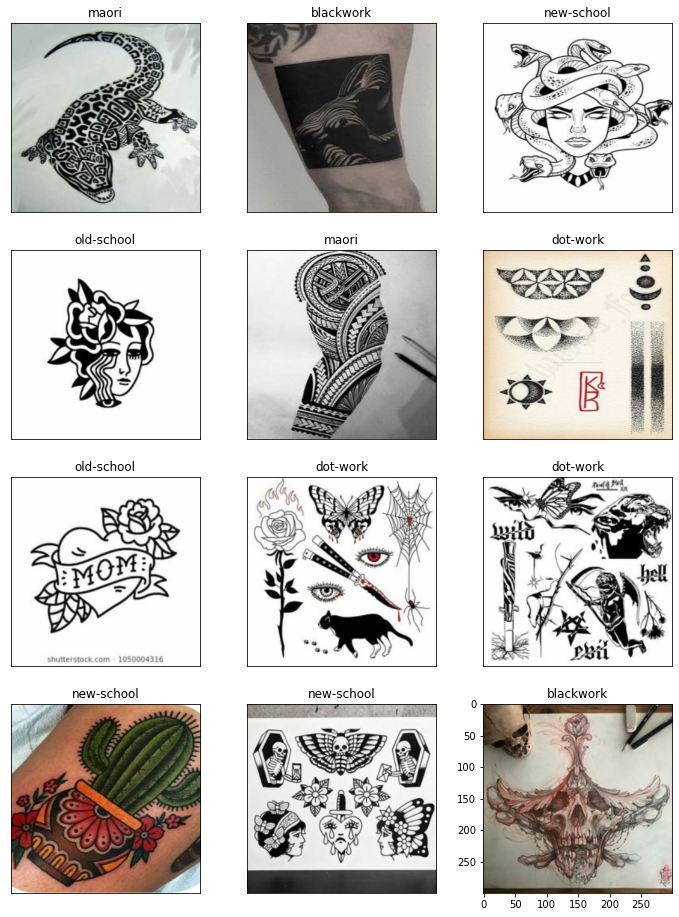

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange

plt.figure(figsize=(12,16))
for a in range(12):
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.subplot(4, 3, a+1)
    i=randrange(len(figs))
    test_fig= figs[i]
    plt.title(cats[i])
    plt.imshow(np.reshape(test_fig, (300, 300, 3)).transpose((0,1,2))/255)


Rodando o código algumas vezes figuras da para ver que as categorias estão bem estabelecidas.  Para que as categorias funcionarem no modelo de rede neural, é necessário que elas se tornem algo numérico e que estejam em forma "dummie", ou seja, com uma coluna representando cada categoria, com valores 0 ou 1 a depender se a figura é ou não da categoria associada. Para isso eu usei um dicionario criado a seguir. Além disso, é necessário dividir Os dados entre dados de treino e dados de teste, para que o modelo possa se avaliar. 

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

label_dict = {}
i = 0
for style in styles:
    label_dict[style] = i
    i += 1

X_train, X_test, y_train, y_test = train_test_split(
    figs,
    pd.get_dummies([label_dict[a] for a in cats]),
    test_size=0.2,
    random_state=42)

Por fim, basta transformar as listas de dados em datasets do tensorflow. A função para isso é simples e faz parte da biblioteca. alem disso, os valores dos canais das figuras devem ser entre 0 e 1, ou seja, é necessário normaliza-los dividindo por (255).

In [15]:
X_train = tf.stack(X_train) / 255
X_test = tf.stack(X_test) / 255
y_train = tf.stack(y_train)
y_test = tf.stack(y_test)

### CNN

Hora de usar os modelos de rede convulocional! Para implementar essa rede, eu usei como molde uma pagina da web escrita por XXXXX (XXXXX). Entretanto, existem diferenças entre a ideia do projeto dele e o que eu quero fazer aqui, por isso eu precisei mudar alguns parametros como a quantidade de filtros na primeira camada, as dimensões da imagem que esta sendo inserida, o tamanho da "piscina" que vai ler a imagem. E alguns parametros de densidade também. Cada parametro foi alterado com base em tentativa e erro, mudando um de cada e vendo as implicações. No codigo abaixo está a implementação do modelo mais preciso que eu consegui. 

In [41]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import datasets, layers, models
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 20, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (300,300,3)))
model.add(MaxPool2D(pool_size=(10,10)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 20, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(10,10), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))


In [42]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
#rodar apenas no primeiro teste
history = model.fit(X_train, y_train,
                    epochs=12, 
                    validation_data=(X_test, y_test))

Epoch 1/12
33/33 [==============================] - 41s 1s/step - loss: 2.0132 - accuracy: 0.1932 - val_loss: 1.8905 - val_accuracy: 0.2278
Epoch 2/12
33/33 [==============================] - 41s 1s/step - loss: 1.8250 - accuracy: 0.2415 - val_loss: 1.8037 - val_accuracy: 0.3629
Epoch 3/12
33/33 [==============================] - 41s 1s/step - loss: 1.6908 - accuracy: 0.3314 - val_loss: 1.6192 - val_accuracy: 0.3707
Epoch 4/12
33/33 [==============================] - 40s 1s/step - loss: 1.5769 - accuracy: 0.3797 - val_loss: 1.5586 - val_accuracy: 0.4093
Epoch 5/12
33/33 [==============================] - 43s 1s/step - loss: 1.5092 - accuracy: 0.3836 - val_loss: 1.4870 - val_accuracy: 0.4479
Epoch 6/12
33/33 [==============================] - 46s 1s/step - loss: 1.4923 - accuracy: 0.4126 - val_loss: 1.5166 - val_accuracy: 0.4015
Epoch 7/12
33/33 [==============================] - 45s 1s/step - loss: 1.4686 - accuracy: 0.4184 - val_loss: 1.4873 - val_accuracy: 0.4517
Epoch 8/12
33/33 [==

Pelas ultimas epocas treinada aqui em cima da pra ver que o modelo tem uma precisão de aproximadamente 50%, ou seja, ele é capaz de prever mais ou menos metade da categoria das tatuagens corretamente. Se tratando de um modelo utilizado para consultas pessoais, que  está avaliando algo abstratado e com um certo quê de ambiguidade, essa precisão está otima.  

Como esse modelo demora um pouquinho para carregar, é interessante salvar os pesos finais obtidos no intuito de poder reutiliza-lo em outros momentos sem precisa treinar a maquinha de novo. Para isso basta salvar os pesos, e depois usar a função "load_weights" para carrega-los. O backup pode ser feito com a linha:

In [20]:
model.save_weights('cnn.h5')

### Avaliando imagens

A ultima etapa desse projeto é usar esse modelo para decidir o estilo que eu vou buscar para minha primeira tatuagem. Ou seja, agora é hora de implementar as imagens que eu desenhei para minha primeira tatuagem e vê em que estilo ela se encaixa. Caso o código tenha sido rodado diretamente ate aqui e o modelo treinado pela primeira vez, não é necessário carregar os pesos  do modelo. Caso seja necessario, basta fazee:

In [44]:
model.load_weights('cnn.h5')

É preciso também carregar o desenho e as montagens que eu fiz para o modelo avaliar. São só 5, e estão todas na pasta "my-one". Também é necessário inverter o dicionario que enumerava os estilos, pois o que queremos é o estilo de acordo com a numeração.

In [53]:
figs= [ decode_image('my-one' + '/' + a, 'png', (300, 300), 3) for a in os.listdir('my-one')]
inverse_dict={v: k for k, v in label_dict.items()}

Feito isso é só rodar o predict, lembrando sempre que o modelo recebe as imagens em formato de tensor e que foi feito com os valores normalizados, ou seja, dividido por 255. O predict na biblioteca keras retorna um array com as probabilidades de ser cada categoria, em que se considera a categoria mais provavel como verdadeira. Por isso, a enumeração é com base no indice do maior argumento, obtido pelo np.argmax()/

In [70]:
labels = [np.argmax(a) for a in model.predict(tf.stack(figs)/255)] 

Agora é só plotar as imagens como no código agora a pouco, fazendo apenas uma pequena modificacão no titulo para corresponder ao estilo previsto pelo modelo. 

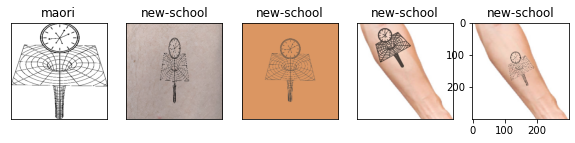

In [74]:
plt.figure(figsize=(10,4))
for a in range(5):
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.subplot(1, 5, a+1)
    i=a
    test_fig= figs[i]
    plt.title(inverse_dict[labels[a]])
    plt.imshow(np.reshape(test_fig, (300, 300, 3)).transpose((0,1,2))/255)

Ao que tudo indica é interessante eu buscar um tatuador no estilo new school!


### Conclusões

Esse código foi feito por mim para meu uso pessoal a respeito de um preciosismo com minha primeira tatuagem, e portanto tem varios detalhes técnicos que podem ser melhorados no futuro. Listando alguns deles:

* É interessante se obter mais figuras de cada categoria de tatuagem, possivelmente atraves dos proprios tatuadores de cada estilo.
* O próprio modelo pode ser melhorado e mais otimizado, a depender da quantidade de figuras e do tempo que se está disposto a gastar melhorando esse modelo.
* Os desenhos a serem previstos podem ser mais também, então eu poderia ter feito mais montagens da tatuagem desejada em diferentes partes do corpo, com diferentes tamanhos e texturas
* É interessante olhar também para a segunda e terceira maior probabilidade, a fim de se ter uma noção melhor de quais são as principais categorias do desenhos aplicados no código.

Por fim, e você conhece um bbom tatuador que faz tattoos no estilo new school em Belo Horizonte - MG, me manda o contato dele! o contato pode ser enviado para neto.cayro@gmail.com, assim como quaisquer eventuais duvidas ou propostas.

In [40]:
keras.backend.clear_session()